In [1]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from collections import Counter

In [80]:
data_path = Path("data")
train_path = data_path / "train_extended.csv"
validation_path = data_path / "validation_extended.csv"
test_path = data_path / "test_extended.csv"

budget = 6250000
AVERAGE_CTR = 0.0007375623256619447


def load_dataset(path):
    return pd.read_csv(path,
                       usecols=["slotwidth", "slotheight", "slotarea", "weekday", "hour", "useragent", "IP", "region",
                                "city",
                                "adexchange", "domain", "url", "urlid", "slotid", 
                                "slotvisibility", "slotformat",
                                "slotprice",
                                "creative", "keypage", "advertiser", "os", "browser"]), \
                       pd.read_csv(path,usecols=["click","payprice"])
                        

def process_data(data):
    le = preprocessing.LabelEncoder()
    return le.fit_transform(data)


def encoding(data):
    data = data.fillna(0)
    data['useragent'] = process_data(data['useragent'])
    data['IP'] = process_data(data['IP'])

    data['region'] = process_data(data['region'])

    data['domain'] = process_data(data.domain.apply(str))

    data['url'] = process_data(data.url.apply(str))

    data['slotid'] = process_data(data['slotid'])

    data['slotvisibility'] = process_data(data['slotvisibility'])

    data['urlid'] = process_data(data['urlid'])

    data['slotformat'] = process_data(data['slotformat'])

    data['creative'] = process_data(data['creative'])

    data['keypage'] = process_data(data.keypage.apply(str))

    data['os'] = process_data(data['os'])
    data['browser'] = process_data(data['browser'])

    return data

def get_won_subset( x, y, bid, budget):
    model, base_bid = bid

    if isinstance(model, list):
        pctrs = []
        for m in model:
            pctrs.append(m.predict(x))
        pctr = np.mean(pctrs, axis=0)
    else:
        pctr = model.predict(x)

    bids = base_bid * (pctr / AVERAGE_CTR)
    
    #print("mean bids", np.mean(bids))

    dataset = y[bids >= y["payprice"]]
    
    

    spend = dataset['payprice'].cumsum()
    dataset = dataset[spend <= budget]

    max_spend = spend.iloc[-1]
    return budget if max_spend > budget else max_spend, dataset



def count_impressions_and_clicks(x, y, bid, budget):
        paid, subdataset = get_won_subset(x, y, bid, budget)

        impressions = len(subdataset)
        clicks = subdataset["click"].sum()

        return paid, impressions, clicks, subdataset



def stats(paid, impressions, clicks):
    return {
        "impressions": impressions,
        "clicks": clicks,
        "CTR": clicks / impressions if impressions else None,
        "spent": paid / 1000,
        "CPM": paid / impressions if impressions else None,
        "CPC": (paid / 1000) / clicks if clicks else None,
    }


def evaluate_bid_strategy(bid, budget, x, y):
        paid, impressions, clicks, subdataset = count_impressions_and_clicks(x, y, bid, budget)

        return stats(paid, impressions, clicks), subdataset


def train_model(X,Y,X_validation,Y_validation):
    y_val = np.asarray(Y_validation['click'])
    tot_val = np.sum(y_val)
    pred_store =[]
    prob_store =[]

    
    #error = np.zeros(len(W))
    #clicks = np.zeros(TRAIN_FOLDS)
    storage = []

    #for k, weight in enumerate(W):
        #print("class weights:", {0: 1, 1: weight})
        
    y_train = np.asarray(Y)

    model = LogisticRegression(solver='liblinear',class_weight={0: 1, 1: 84}, max_iter=200, multi_class='ovr')

    model.fit(X, np.reshape(y_train, (len(y_train),)))
        
    pred_train = model.predict(X)
        
    pred_val = model.predict(X_validation)
    prob = model.predict_proba(X_validation)
            
            
    #print('predictions',np.sum(pred_val))

    #error = np.abs(np.sum(pred_val - y_val.reshape((y_val.shape[0],)))) / tot_val
    print('roc score:', metrics.roc_auc_score(y_val, pred_val))
    #print('error on training set:', np.abs(np.sum(pred_train - y_train.reshape((y_train.shape[0],)))) / np.sum(y_train))
    #print('error on validation set:', np.abs(np.sum(pred_val - y_val.reshape((y_val.shape[0],)))) / tot_val)

    pred_store.append([pred_val])
    prob_store.append([prob])
            
    pCTR = prob[:,1]
    
    for my_bid in np.arange(0.001,0.3,0.005):
        
        bid = (model,my_bid)
        
        print("bid",my_bid)
        result,_ = evaluate_bid_strategy(bid,budget,X_validation,Y_validation)

        print(result)
            
        #mean_clicks = np.mean(clicks)
        #storage.append([[result],[pCTR],[weight]])
        storage.append([result])

    return model,storage



In [3]:
X_train, Y_train = load_dataset('data\\train_extended.csv')
X_train = encoding(X_train)

In [67]:
def bid_on_test(model,base_bid):

    test_x = load_dataset('data\\test_extended.csv')
    ids = pd.read_csv('data\\test_extended.csv', usecols=["bidid"])

    print("Loaded test")
    #print(test_x.head)
    test_x = encoding(test_x)
    pctr = model.predict_proba(test_x)
    
    
    plt.hist(pctr[:,1])
    
    bids = base_bid * (pctr[:,1] / AVERAGE_CTR)
    
    bids[bids < 0] = 0

    bids = bids.astype(np.float)
    
    print(bids)

    df = pd.DataFrame({"bidid": ids["bidid"].values, "bidprice": bids}, index=None)


    return df


In [81]:
print('Original dataset shape %s' % Counter(Y_train['click']))

store = []

sample_ratio = np.arange(0.008,0.014,0.0005)
W = np.arange(60, 120, 2)
#for i in sample_ratio:

rus = RandomUnderSampler(sampling_strategy=0.0105,random_state=42)
X_res, y_res = rus.fit_resample(X_train, Y_train['click'])

print('New dataset shape %s' % Counter(y_res))

X_validation, Y_validation = load_dataset('data\\validation_extended.csv')
X_validation = encoding(X_validation)

model, results = train_model(X_res,y_res,X_validation,Y_validation)
    
store.append([results])

Original dataset shape Counter({0: 2429188, 1: 1793})
New dataset shape Counter({0: 170761, 1: 1793})
roc score: 0.6457827258116217
bid 0.001
{'impressions': 137, 'clicks': 0, 'CTR': 0.0, 'spent': 0.055, 'CPM': 0.40145985401459855, 'CPC': None}
bid 0.006
{'impressions': 1761, 'clicks': 4, 'CTR': 0.002271436683702442, 'spent': 9.186, 'CPM': 5.216354344122657, 'CPC': 2.2965}
bid 0.011
{'impressions': 3170, 'clicks': 4, 'CTR': 0.0012618296529968455, 'spent': 25.398, 'CPM': 8.01198738170347, 'CPC': 6.3495}
bid 0.016
{'impressions': 7547, 'clicks': 6, 'CTR': 0.0007950178879024779, 'spent': 108.103, 'CPM': 14.323969789320259, 'CPC': 18.017166666666665}
bid 0.021
{'impressions': 9338, 'clicks': 7, 'CTR': 0.0007496251874062968, 'spent': 151.462, 'CPM': 16.219961447847506, 'CPC': 21.63742857142857}
bid 0.026000000000000002
{'impressions': 13062, 'clicks': 12, 'CTR': 0.0009186954524575103, 'spent': 268.021, 'CPM': 20.519139488592863, 'CPC': 22.335083333333333}
bid 0.031
{'impressions': 14458, 'c

{'impressions': 75490, 'clicks': 109, 'CTR': 0.0014438998542853358, 'spent': 6229.509, 'CPM': 82.52098291164393, 'CPC': 57.15145871559633}
bid 0.28600000000000003
{'impressions': 75490, 'clicks': 109, 'CTR': 0.0014438998542853358, 'spent': 6229.509, 'CPM': 82.52098291164393, 'CPC': 57.15145871559633}
bid 0.291
{'impressions': 75490, 'clicks': 109, 'CTR': 0.0014438998542853358, 'spent': 6229.509, 'CPM': 82.52098291164393, 'CPC': 57.15145871559633}
bid 0.296
{'impressions': 75490, 'clicks': 109, 'CTR': 0.0014438998542853358, 'spent': 6229.509, 'CPM': 82.52098291164393, 'CPC': 57.15145871559633}


Loaded test
[1280.59823204 2448.45953749 1621.63376481 ... 1402.73864196 1489.89234661
 1005.51814774]


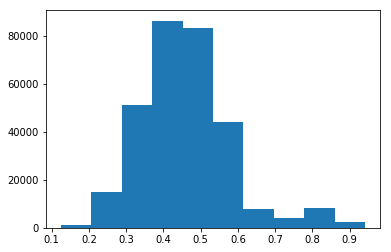

In [68]:
df = bid_on_test(model,2.2)

In [69]:
df.to_csv("testing_bidding_price_linear.csv.csv", index=None)

In [164]:
with open('dump_results_param_tune_clicks.pickle', 'wb') as handle:
           pickle.dump(store, handle)

(12, 30)


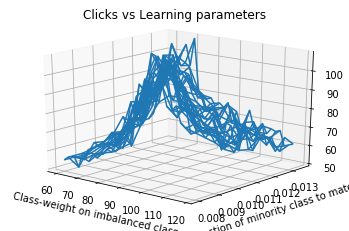

In [72]:
with open('dump_results_param_tune_clicks.pickle', 'rb') as f:
    store = pickle.load(f)
    
sample_ratio = np.arange(0.008,0.014,0.0005)
weights = np.arange(60, 120, 2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

clicks = np.zeros((len(sample_ratio),len(weights)))
for a in range (len(sample_ratio)): 
    for b in range(len(weights)):
         clicks[a,b] = store[a][0][0][b][0][0]['clicks']
            
print(clicks.shape)


x_axis, y_axis = np.meshgrid(weights,sample_ratio)
ax.plot_wireframe(x_axis, y_axis, clicks,rstride=1, cstride=1)

ax.set_xlabel('Class-weight on imbalanced class')
ax.set_ylabel('Franction of minority class to matority')
ax.set_zlabel('Clicks')
ax.set_title('Clicks vs Learning parameters')

ax.view_init(azim=-50, elev=20)

#plt.show()

4


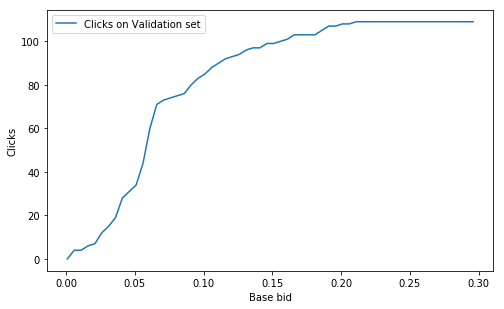

In [88]:
bids = np.arange(0.001,0.3,0.005)

clicks = np.zeros(len(bids))

print(results[1][0]['clicks'])
for a in range(len(bids)):
    clicks[a] = results[a][0]['clicks'] 
    

fig = plt.figure(figsize=[8,4.8])
ax = plt.subplot(111)
ax.plot(bids,clicks)

ax.set_xlabel('Base bid')
ax.set_ylabel('Clicks')
ax.legend(['Clicks on Validation set'])

  
plt.savefig('Linear_bidding_basebidVsClicks.pdf')